> ⚠️
> **This project is still in an early phase of development.**
>
> The [python API](../api.html) is not yet stable, and some aspects of the schema for the [blueprint](../terminology.html#term-blueprint) will likely evolve. 
> Therefore whilst you are welcome to try out using the package, we cannot yet guarantee backwards compatibility. 
We expect to reach a more stable version in 2026.
>
> To see which systems C-Star has been tested on so far, see [Supported Systems](../machines.html).

# Importing & running a `Simulation` from a blueprint


## Contents
1. [Introduction](#1.-Introduction)
2. [Importing the Simulation](#2.-Importing-the-Simulation)
3. [Setting up the Simulation](#3.-Setting-up-the-Simulation)
4. [Compiling the Simulation and performing pre-processing](#4.-Compiling-the-Simulation-and-performing-pre-processing)
5. [Running the Simulation](#5.-Running-the-Simulation)
6. [Post-processing](#6.-Post\-processing)
7. [A quick look at the output](#7.-A-quick-look-at-the-output)
8. [Summary](#8.-Summary)

## 1. Introduction 
[(return to top)](#Contents)

On this page, we will import and execute a ROMS-MARBL [Simulation](../terminology.html#term-Simulation) (constructed and exported on [the previous page](../tutorials/1_building_a_simulation_and_exporting_it_as_a_blueprint.html)) using C-Star. In particular, we will:

- Create a Simulation from a pre-prepared [blueprint](../terminology.html#term-blueprint) (`ROMSSimulation.from_blueprint()`). See  for more information on blueprints and how to create them.
- Set up the simulation locally (`ROMSSimulation.setup()`)
- Compile any necessary code associated with the simulation (`ROMSSimulation.build()`)
- Complete any pre-processing steps associated with the simulation (`ROMSSimulation.pre_run()`)
- Run the case with a small time step for a couple of simulation (`ROMSSimulation.run()`)
- Execute any post-processing steps associated with the simulation (`ROMSSimulation.post_run()`)

## 2. Importing the `Simulation` 
[(return to top)](#Contents)

We can construct a `ROMSSimulation` from a blueprint using the `ROMSSimulation.from_blueprint` method. The case we'll be looking at in this example is a January 2012 simulation of ocean physics and biogeochemistry around the Welsh coast, small enough to run on a laptop.

In [1]:
from cstar.roms import ROMSSimulation

example_simulation_1 = ROMSSimulation.from_blueprint(blueprint  = "roms_marbl_example_simulation.yaml", # this can be a local path or URL to your blueprint 
                                           directory  = "../../examples/roms_marbl_example_case", # where you would like to setup and run the simulation
                                           start_date = "2012-01-01 12:00:00", # The dates between which you would like to run the Simulation
                                           end_date   = "2012-01-03 12:00:00")


The arguments are:
- `blueprint`: the local path or URL to your blueprint file
- `directory` : where you would like C-Star to assemble and run your `Case`
- `start_` and `end_date` : the dates you would like to run the simulation. An error will be raised if these dates fall outside the valid date range supported by the blueprint.

As a reminder, here's an overview of the `Simulation` we just created from our blueprint. For a complete deconstruction of the `Simulation`, see the [the previous page](../tutorials/1_building_a_simulation_and_exporting_it_as_a_blueprint.html):

In [2]:
print(example_simulation_1)

ROMSSimulation
--------------
Name: roms_marbl_example_cstar_simulation
Directory: /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case
Start date: 2012-01-01 12:00:00
End date: 2012-01-03 12:00:00
Valid start date: 2012-01-01 12:00:00
Valid end date: 2012-01-31 12:00:00

Discretization: ROMSDiscretization(time_step = 60, n_procs_x = 3, n_procs_y = 3)

Code:
Codebase: ROMSExternalCodeBase instance (query using ROMSSimulation.codebase)
Runtime code: AdditionalCode instance with 4 files (query using ROMSSimulation.runtime_code)
Compile-time code: AdditionalCode instance with 10 files (query using ROMSSimulation.compile_time_code)
MARBL Codebase: MARBLExternalCodeBase instance (query using ROMSSimulation.marbl_codebase)

Input Datasets:
Model grid: <ROMSModelGrid instance>
Initial conditions: <ROMSInitialConditions instance>
Tidal forcing: <ROMSTidalForcing instance>
River forcing: <ROMSRiverForcing instance>
Surface forcing: <list of 2 ROMSSurfaceForcing instances>
Bou

In [3]:
print(example_simulation_1.tree())

/Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case
└── ROMS
    ├── input_datasets
    │   ├── roms_grd.nc
    │   ├── roms_ini.nc
    │   ├── roms_tides.nc
    │   ├── roms_riv_frc.nc
    │   ├── roms_bry.nc
    │   ├── roms_bry_bgc.nc
    │   ├── roms_frc.nc
    │   └── roms_frc_bgc.nc
    ├── runtime_code
    │   ├── roms.in
    │   ├── marbl_in
    │   ├── marbl_tracer_output_list
    │   └── marbl_diagnostic_output_list
    └── compile_time_code
        ├── bgc.opt
        ├── bulk_frc.opt
        ├── cppdefs.opt
        ├── diagnostics.opt
        ├── ocean_vars.opt
        ├── param.opt
        ├── tracers.opt
        ├── river_frc.opt
        ├── Makefile
        └── Make.depend



<div class="alert alert-info">

Note

Nothing we have seen above represents anything local on our machine (yet). Each object simply describes where various files may be found, and the `ROMSSimulation.tree()` representation shows us where these files will be assembled once we set everything up. To turn that into something concrete we can work with, we call `ROMSSimulation.setup()`.

</div>

## 3. Setting up the `Simulation`
[(return to top)](#Contents)

Next we call `ROMSSimulation.setup()`. This will:

- Fetch and compile any external codebases (ROMS and MARBL)
- Fetch any remote data associated with this case
- Construct any ROMS netCDF files from yaml files using `roms-tools` 

We will be prompted before installing the base models, so some input is required here:

In [4]:
example_simulation_1.setup()

[INFO] 🛠️  Configuring ROMSSimulation
[INFO] 🔧 Setting up ROMSExternalCodeBase...
#######################################################
C-STAR: ROMS_ROOT not found in current cstar_sysmgr.environment. 
if this is your first time running C-Star with an instance of ROMSExternalCodeBase, you will need to set it up.
It is recommended that you install this external codebase in 
/Users/dafyddstephenson/Code/my_c_star/cstar/externals/ucla-roms
This will also modify your `~/.cstar.env` file.
#######################################################


Would you like to do this now? ('y', 'n', or 'custom' to install at a custom path)
 y


[INFO] Updating environment in C-Star configuration file /Users/dafyddstephenson/.cstar.env
[INFO] 🔧 Setting up MARBLExternalCodeBase...
#######################################################
C-STAR: MARBL_ROOT not found in current cstar_sysmgr.environment. 
if this is your first time running C-Star with an instance of MARBLExternalCodeBase, you will need to set it up.
It is recommended that you install this external codebase in 
/Users/dafyddstephenson/Code/my_c_star/cstar/externals/MARBL
This will also modify your `~/.cstar.env` file.
#######################################################


Would you like to do this now? ('y', 'n', or 'custom' to install at a custom path)
 y


[INFO] Updating environment in C-Star configuration file /Users/dafyddstephenson/.cstar.env
[INFO] 📦 Fetching compile-time code...
[INFO] • Copying bgc.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/compile_time_code
[INFO] • Copying bulk_frc.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/compile_time_code
[INFO] • Copying cppdefs.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/compile_time_code
[INFO] • Copying diagnostics.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/compile_time_code
[INFO] • Copying ocean_vars.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/compile_time_code
[INFO] • Copying param.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/compile_time_code
[INFO] • Copying tracers.opt to /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/R

## 4. Compiling the `Simulation` and performing pre-processing
[(return to top)](#Contents)

We have now assembled all the data we need to run this `Simulation` in one place. Lastly, we need to compile the additional code we've obtained and run some pre-processing steps on the input data:

In [5]:
#The Simulation.build() method compiles the code:
example_simulation_1.build()


In [6]:
# The Simulation.pre_run() method performs pre-processing:
example_simulation_1.pre_run()

[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_grd.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_ini.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_tides.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_riv_frc.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_bry.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_bry_bgc.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/Code/my_c_star/examples/roms_marbl_example_case/ROMS/input_datasets/roms_frc.nc into (3,3)
[INFO] Partitioning /Users/dafyddstephenson/C

## 5. Running the `Simulation`

[(return to top)](#Contents)

In [7]:
simulation_run = example_simulation_1.run()

<div class="alert alert-info">

Note

Here we call `ROMSSimulation.run()` without arguments under the assumption we are running this (small) simulation locally, on a personal computer.

- For more information on local process runs, see this [how-to guide](../howto_guides/4_running_on_personal_computers.html).
- For information on running on a supported supercomputing system, see [the corresponding doc page](../howto_guides/5_handling_jobs_on_hpc_systems.ipynb).

</div>

We can track the status of the submitted job using [LocalProcess.status](../generated/cstar.execution.local_process.LocalProcess.html#cstar.execution.local_process.LocalProcess.status). It will change from:

In [8]:
simulation_run.status

<ExecutionStatus.RUNNING: 3>

(while executing) to:

In [9]:
simulation_run.status

<ExecutionStatus.COMPLETED: 4>

(when finished). 

## 6. Post-processing

[(return to top)](#Contents)

Once the run is complete, we can carry out any post-processing steps.
When ROMS runs on multiple CPUs in parallel, it produces one output file per CPU. To work with the output, we thus need to join these files together. This is handled with the `post_run()` method:

In [10]:
example_simulation_1.post_run()

[INFO] Joining netCDF files ROMS_MARBL_his.20120101120000.*.nc...
[INFO] Joining netCDF files ROMS_MARBL_bgc_dia.20120101120000.*.nc...
[INFO] Joining netCDF files ROMS_MARBL_bgc.20120101120000.*.nc...
[INFO] Joining netCDF files ROMS_MARBL_rst.20120103120000.*.nc...
[INFO] Joining netCDF files ROMS_MARBL_rst.20120102120000.*.nc...


## 7. A quick look at the output

[(return to top)](#Contents)

In the above post-processing step, we can see that the ROMS run produced several "restart" files (`ROMS_MARBL_rst.*`) that can be used by ROMS to restart the run.
On the [next page](../tutorials/3_restarting_and_continuing_a_simulation.html), we will use C-Star to restart and continue our Case, and C-Star will find and use these files to do so.

For now, let's produce a plot comparing the initial condition we started with with the final restart file (which will serve as the initial condition on the [next page](../tutorials/3_restarting_and_continuing_a_simulation.html)).

C-Star doesn't currently support plots of model data, so we will have to manually produce these using the model files. Don't worry too much about understanding the model's naming conventions in this code cell (C-Star will usually take care of these things for you) - this is just a visual demonstration!

In [11]:
%matplotlib inline

/var/folders/1s/xjsjyqrj2rdft8014664qczc0000gn/T/ipykernel_64746/2152813927.py:8: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ini_ds = xr.open_dataset(example_simulation_1.directory / 'ROMS/input_datasets/roms_ini.nc') # Our initial condition file
/var/folders/1s/xjsjyqrj2rdft8014664qczc0000gn/T/ipykernel_64746/2152813927.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


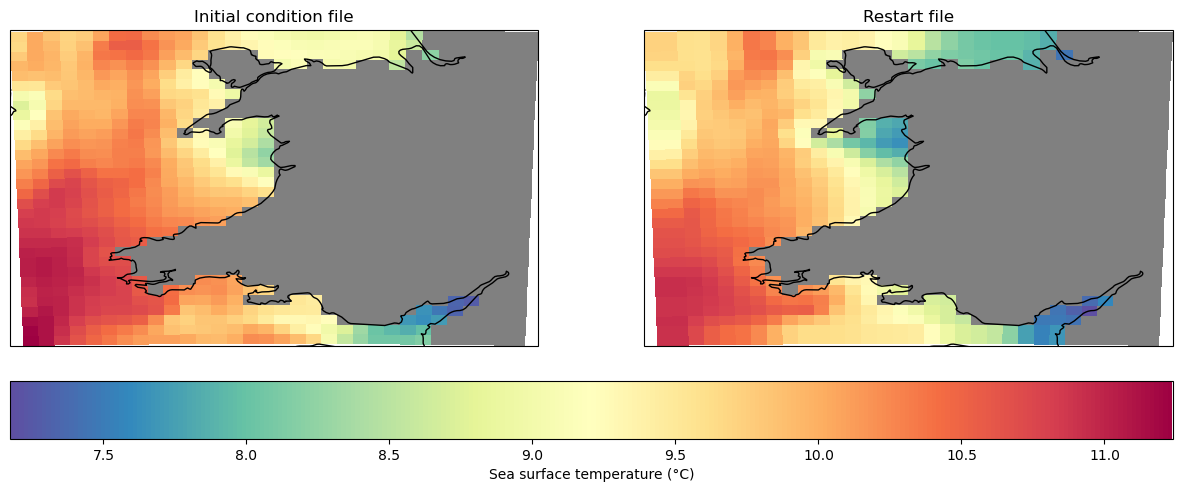

In [12]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

grd_ds = xr.open_dataset(example_simulation_1.directory / 'ROMS/input_datasets/roms_grd.nc') # Our ROMS grid file for lat and lon data
ini_ds = xr.open_dataset(example_simulation_1.directory / 'ROMS/input_datasets/roms_ini.nc') # Our initial condition file
rst_ds = xr.open_dataset(example_simulation_1.directory / 'output/ROMS_MARBL_rst.20120103120000.nc') # Our restart file

var="temp"
ini_data = ini_ds[var].where(grd_ds.mask_rho).isel(s_rho=-1, ocean_time=0)
rst_data = rst_ds[var].where(grd_ds.mask_rho).isel(s_rho=-1, time=0)

# Create figure and axes
fig, ax = plt.subplots(1,2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(15, 9))

# Plot the data
cmap=plt.get_cmap('Spectral_r')
cmap.set_bad('gray')
vmin = min(ini_data.where(grd_ds.mask_rho).min(), rst_data.where(grd_ds.mask_rho).min())
vmax = max(ini_data.where(grd_ds.mask_rho).max(), rst_data.where(grd_ds.mask_rho).max())
kwargs = {"cmap": cmap, "vmin": vmin, "vmax": vmax}
p0=ax[0].pcolormesh(grd_ds.lon_rho, grd_ds.lat_rho, ini_data, transform=ccrs.PlateCarree(), **kwargs)
p1=ax[1].pcolormesh(grd_ds.lon_rho, grd_ds.lat_rho, rst_data, transform=ccrs.PlateCarree(), **kwargs)

# Add coastlines and land mask 
[a.add_feature(cfeature.COASTLINE, linewidth=1) for a in ax]

# Add a colorbar
ax[0].set_title("Initial condition file")
ax[1].set_title("Restart file")
plt.colorbar(p1, ax=ax, orientation='horizontal', pad=0.05,label="Sea surface temperature (°C)")
fig.show()
grd_ds.close()


## 8. Summary
[return to top](#Contents)

On this page we:

- created a C-Star `Simulation` from a "blueprint" file
- Ran the case for 2 days from 2012-01-01 to 2012-01-03 with a 1 minute time-step
- Produced a basic plot to verify the output

On the [next page](../tutorials/3_restarting_and_continuing_a_simulation.html) we will "restart" the `Simulation`, running it with a larger time-step for the remainder of January 2012.